# Download & Preprocess the IMDB Dataset

In [1]:
# Download reviews.txt and labels.txt from here: https://github.com/udacity/deep-learning/tree/master/sentiment-network

def pretty_print_review_and_label(i):
   print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('reviews.txt','r') # What we know!
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('labels.txt','r') # What we WANT to know!
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()


# Preprocess dataset:

import sys

f = open('reviews.txt')
raw_reviews = f.readlines()
f.close()

f = open('labels.txt')
raw_labels = f.readlines()
f.close()

tokens = list(map(lambda x:set(x.split(" ")),raw_reviews))

vocab = set()
for sent in tokens:
    for word in sent:
        if(len(word)>0):
            vocab.add(word)
vocab = list(vocab)

word2index = {}
for i,word in enumerate(vocab):
    word2index[word]=i

input_dataset = list()
for sent in tokens:
    sent_indices = list()
    for word in sent:
        try:
            sent_indices.append(word2index[word])
        except:
            ""
    input_dataset.append(list(set(sent_indices)))

target_dataset = list()
for label in raw_labels:
    if label == 'positive\n':
        target_dataset.append(1)
    else:
        target_dataset.append(0)

In [9]:
# NN (original version)
import numpy as np

np.random.seed(1)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoidd(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return (x>0) * x

def relud(x):
    return x>0

alpha, iterations = (0.01, 2)
hidden_size = 10

weights_0_1 = 0.2*np.random.random((len(vocab), hidden_size)) - 0.1 # vocab to hidden
weights_1_2 = 0.2*np.random.random((hidden_size, 1)) - 0.1 # hidden to 1

correct, total = (0, 0)

for iter in range(iterations):
    
    # train on first 24,000
    for i in range(len(input_dataset) - 1000):

        x, y = (input_dataset[i], target_dataset[i]) # i-th element of dataset
        
        layer_1 = sigmoid(np.sum(weights_0_1[x], axis=0)) # embed + sigmoid: one-hot encoding: summation faster than product
        layer_2 = sigmoid(np.dot(layer_1, weights_1_2)) # linear + softmax

        layer_2_delta = layer_2 - y # compare pred with truth = error
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) # backprop
        
        # W_1_2-=alpha * L2delta * sigmoidd(L1 * W_1_2) * L1 -> alpha * L2delta * L1
        # W_0_1-=alpha * L1delta * sigmoidd(L1 * W_1_2) * sigmoidd(W_0_1 * x) * x -> alpha * L1delta # x dropped since W_0_1[x]
        weights_0_1[x] -= layer_1_delta * alpha # weight updates: sig' = approx 1/4 (Taylor exp. 1/2+x/4+-...)
        weights_1_2 -= np.outer(layer_1, layer_2_delta) * alpha
        
        if(np.abs(layer_2_delta) < 0.5): # is it a close fit?
            correct += 1 # increment correct guesses
            
        total += 1 # total guesses
        
        if(i % 20 == 1):
            progress = str(i/float(len(input_dataset)))
            sys.stdout.write('\rIter:'+str(iter)\
                             +' Progress:'+progress[2:4]\
                             +'.'+progress[4:6]\
                             +'% Training Accuracy:'\
                             + str(correct/float(total)) + '%')
    
    print()
    
correct, total = (0, 0)

for i in range(len(input_dataset)-1000, len(input_dataset)): # use the last 1000 as test

    x = input_dataset[i]
    y = target_dataset[i]

    layer_1 = sigmoid(np.sum(weights_0_1[x], axis=0))
    layer_2 = sigmoid(np.dot(layer_1, weights_1_2))
    
    if(np.abs(layer_2 - y) < 0.5):
        correct += 1
    total += 1
print("Test Accuracy:" + str(correct / float(total)))

Iter:0 Progress:95.92% Training Accuracy:0.8164039696438996%%
Iter:1 Progress:95.92% Training Accuracy:0.8575090658997124%
Test Accuracy:0.852


# The Surprising Power of Averaged Word Vectors

[ 0.11629306 -7.33107774 -3.28265491  2.96615504 -8.57442025  7.42941586
  7.04248413 -3.85775863 -2.56417646  4.24056126]
['the characters are unlikeable and the sc', 'this movie is so bad  it can only be com', 'this is without a doubt the worst movie ', 'i  ve seen about    movies released betw', 'this was one of the worst movies i have ']


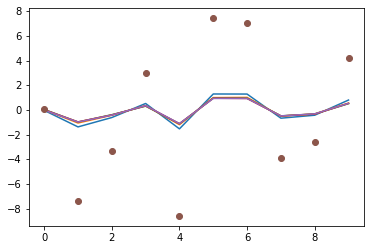

In [16]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

norms = np.sum(weights_0_1 * weights_0_1, axis=1)
norms.resize(norms.shape[0],1)
normed_weights = weights_0_1 * norms

def make_sent_vect(words):
    indices = list(map(lambda x:word2index[x], filter(lambda x:x in word2index, words)))
    return np.mean(normed_weights[indices], axis=0)

reviews2vectors = list()
for review in tokens: # tokenized reviews
    reviews2vectors.append(make_sent_vect(review))
reviews2vectors = np.array(reviews2vectors)

def most_similar_reviews(review, ntop=3):
    v = make_sent_vect(review)
    print(v)
    scores = Counter()
    for i, val in enumerate(reviews2vectors.dot(v)): # dot-product similarity
        scores[i] = val
        
    most_similar = list()
    for idx, score in scores.most_common(ntop):
        most_similar.append(raw_reviews[idx][0:40])
        plt.plot(reviews2vectors[idx]) # show most similar review word vectors
    plt.plot(v, 'o')
    return most_similar

print(most_similar_reviews(['boring', 'awful'], 5))
plt.show()

# Matrices that Change Absolutely Nothing

In [17]:
import numpy as np

a = np.array([1,2,3])
b = np.array([0.1,0.2,0.3])
c = np.array([-1,-0.5,0])
d = np.array([0,0,0])

identity = np.eye(3)
print(identity)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [18]:
print(a.dot(identity))
print(b.dot(identity))
print(c.dot(identity))
print(d.dot(identity))

[1. 2. 3.]
[0.1 0.2 0.3]
[-1.  -0.5  0. ]
[0. 0. 0.]


In [19]:
this = np.array([2,4,6])
movie = np.array([10,10,10])
rocks = np.array([1,1,1])

print(this + movie + rocks)
print((this.dot(identity) + movie).dot(identity) + rocks)

[13 15 17]
[13. 15. 17.]


# Forward Propagation in Python

In [30]:
import numpy as np

def softmax(x_):
    x = np.atleast_2d(x_)
    temp = np.exp(x)
    return temp / np.sum(temp, axis=1, keepdims=True)

word_vects = {}
word_vects['yankees'] = np.array([[0.,0.,0.]])
word_vects['bears'] = np.array([[0.,0.,0.]])
word_vects['braves'] = np.array([[0.,0.,0.]])
word_vects['red'] = np.array([[0.,0.,0.]])
word_vects['socks'] = np.array([[0.,0.,0.]])
word_vects['lose'] = np.array([[0.,0.,0.]])
word_vects['defeat'] = np.array([[0.,0.,0.]])
word_vects['beat'] = np.array([[0.,0.,0.]])
word_vects['tie'] = np.array([[0.,0.,0.]])

sent2output = np.random.rand(3, len(word_vects))

identity = np.eye(3) # eye: returns id-matrix

In [32]:
layer_0 = word_vects['red']
layer_1 = layer_0.dot(identity) + word_vects['socks']
layer_2 = layer_1.dot(identity) + word_vects['defeat']

pred = softmax(layer_2.dot(sent2output)) # forward prop

print(layer_2)
print(sent2output)
print('prediction:', pred)

[[0. 0. 0.]]
[[0.91063368 0.08028843 0.94321154 0.63338327 0.9655085  0.7291186
  0.73045693 0.4120407  0.71376408]
 [0.67646957 0.27824081 0.21080892 0.38702292 0.42557053 0.14631184
  0.36863566 0.25976257 0.15845981]
 [0.88471383 0.21714672 0.47664916 0.48413108 0.82606822 0.80933
  0.75727878 0.49472755 0.59946693]]
prediction: [[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
  0.11111111 0.11111111 0.11111111]]


# How do we Backpropagate into this?

In [28]:
y = np.array([1,0,0,0,0,0,0,0,0]) # target one-hot vector for "yankees"

pred_delta = pred - y
layer_2_delta = pred_delta.dot(sent2output.T)
defeat_delta = layer_2_delta * 1 # can ignore the "1" like prev. chapter
layer_1_delta = layer_2_delta.dot(identity.T)
socks_delta = layer_1_delta * 1 # again... can ignore the "1"
layer_0_delta = layer_1_delta.dot(identity.T)

alpha = 0.01
word_vects['red'] -= layer_0_delta * alpha
word_vects['socks'] -= socks_delta * alpha
word_vects['defeat'] -= defeat_delta * alpha

identity -= np.outer(layer_0, layer_1_delta) * alpha # weight updates
identity -= np.outer(layer_1, layer_2_delta) * alpha
sent2output -= np.outer(layer_2, pred_delta) * alpha

print(sent2output)
print(word_vects)

[[0.37308671 0.98699617 0.85995811 0.22377186 0.39743257 0.14405549
  0.19941871 0.30156922 0.88931055]
 [0.11577173 0.69162203 0.0193296  0.53357674 0.92731954 0.195463
  0.22111529 0.38083827 0.62331081]
 [0.02037032 0.50525552 0.14917324 0.64613454 0.54549646 0.17000143
  0.56655313 0.43763237 0.97359202]]
{'yankees': array([[0., 0., 0.]]), 'bears': array([[0., 0., 0.]]), 'braves': array([[0., 0., 0.]]), 'red': array([[-0.00226188, -0.0059255 , -0.0085133 ]]), 'socks': array([[-0.00226185, -0.00592542, -0.00851318]]), 'lose': array([[0., 0., 0.]]), 'defeat': array([[-0.00226182, -0.00592534, -0.00851306]]), 'beat': array([[0., 0., 0.]]), 'tie': array([[0., 0., 0.]])}


# Let's Train it!

In [34]:
import sys,random,math
from collections import Counter
import numpy as np

f = open('qa1_single-supporting-fact_train.txt','r')
raw = f.readlines()
f.close()

tokens = list()
for line in raw[0:1000]:
    tokens.append(line.lower().replace("\n","").split(" ")[1:])

print(tokens[0:3])

[['john', 'travelled', 'to', 'the', 'hallway.'], ['mary', 'journeyed', 'to', 'the', 'bathroom.'], ['where', 'is', 'john?', '\thallway\t1']]


In [35]:
vocab = set()
for sent in tokens:
    for word in sent:
        vocab.add(word)

vocab = list(vocab)

word2index = {}
for i,word in enumerate(vocab):
    word2index[word]=i
    
def words2indices(sentence):
    idx = list()
    for word in sentence:
        idx.append(word2index[word])
    return idx

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [36]:
np.random.seed(1)
embed_size = 10

# word embeddings
embed = (np.random.rand(len(vocab),embed_size) - 0.5) * 0.1

# embedding -> embedding (initially the identity matrix)
recurrent = np.eye(embed_size)

# sentence embedding for empty sentence
start = np.zeros(embed_size)

# embedding -> output weights
decoder = (np.random.rand(embed_size, len(vocab)) - 0.5) * 0.1

# one hot lookups (for loss function)
one_hot = np.eye(len(vocab))

# Forward Propagation with Arbitrary Length

In [37]:
def predict(sent):
    
    layers = list()
    layer = {}
    layer['hidden'] = start
    layers.append(layer)

    loss = 0

    # forward propagate
    preds = list()
    for target_i in range(len(sent)):

        layer = {}

        # try to predict the next term
        layer['pred'] = softmax(layers[-1]['hidden'].dot(decoder))

        loss += -np.log(layer['pred'][sent[target_i]])

        # generate the next hidden state
        layer['hidden'] = layers[-1]['hidden'].dot(recurrent) + embed[sent[target_i]]
        layers.append(layer)

    return layers, loss

# Backpropagation with Arbitrary Length

In [38]:
# forward
for iter in range(30000):
    alpha = 0.001
    sent = words2indices(tokens[iter%len(tokens)][1:])
    layers,loss = predict(sent) 

    # back propagate
    for layer_idx in reversed(range(len(layers))):
        layer = layers[layer_idx]
        target = sent[layer_idx-1]

        if(layer_idx > 0):  # if not the first layer
            layer['output_delta'] = layer['pred'] - one_hot[target]
            new_hidden_delta = layer['output_delta'].dot(decoder.transpose())

            # if the last layer - don't pull from a later one becasue it doesn't exist
            if(layer_idx == len(layers)-1):
                layer['hidden_delta'] = new_hidden_delta
            else:
                layer['hidden_delta'] = new_hidden_delta + layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())
        else: # if the first layer
            layer['hidden_delta'] = layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())

# Weight Update with Arbitrary Length

In [39]:
# forward
for iter in range(30000):
    alpha = 0.001
    sent = words2indices(tokens[iter%len(tokens)][1:])

    layers,loss = predict(sent) 

    # back propagate
    for layer_idx in reversed(range(len(layers))):
        layer = layers[layer_idx]
        target = sent[layer_idx-1]

        if(layer_idx > 0):
            layer['output_delta'] = layer['pred'] - one_hot[target]
            new_hidden_delta = layer['output_delta'].dot(decoder.transpose())

            # if the last layer - don't pull from a 
            # later one becasue it doesn't exist
            if(layer_idx == len(layers)-1):
                layer['hidden_delta'] = new_hidden_delta
            else:
                layer['hidden_delta'] = new_hidden_delta + layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())
        else:
            layer['hidden_delta'] = layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())

    # update weights
    start -= layers[0]['hidden_delta'] * alpha / float(len(sent))
    for layer_idx,layer in enumerate(layers[1:]):
        
        decoder -= np.outer(layers[layer_idx]['hidden'], layer['output_delta']) * alpha / float(len(sent))
        
        embed_idx = sent[layer_idx]
        embed[embed_idx] -= layers[layer_idx]['hidden_delta'] * alpha / float(len(sent))
        recurrent -= np.outer(layers[layer_idx]['hidden'], layer['hidden_delta']) * alpha / float(len(sent))
        
    if(iter % 1000 == 0):
        print("Perplexity:" + str(np.exp(loss/len(sent))))

Perplexity:81.08812874281222
Perplexity:80.94057641998825
Perplexity:80.74658557063212
Perplexity:80.44086234167231
Perplexity:79.90436968255443
Perplexity:78.88251420717953
Perplexity:76.7231013651752
Perplexity:71.14663366447378
Perplexity:48.54011702437526
Perplexity:28.975543950395423
Perplexity:22.50366907200615
Perplexity:21.16184633378187
Perplexity:20.08541174396922
Perplexity:18.618579250105174
Perplexity:16.26816238265141
Perplexity:12.941013686366436
Perplexity:9.744360094074626
Perplexity:8.197901438571844
Perplexity:7.276779848939655
Perplexity:6.662493567341839
Perplexity:6.2415647292337955
Perplexity:5.961263401371822
Perplexity:5.7735848775236756
Perplexity:5.63525478280964
Perplexity:5.513981683391327
Perplexity:5.395991693487238
Perplexity:5.2809916169580235
Perplexity:5.173001832978402
Perplexity:5.077100079485485
Perplexity:4.994391131105561


# Execution and Output Analysis

In [40]:
sent_index = 4

l,_ = predict(words2indices(tokens[sent_index]))

print(tokens[sent_index])

for i,each_layer in enumerate(l[1:-1]):
    input = tokens[sent_index][i]
    true = tokens[sent_index][i+1]
    pred = vocab[each_layer['pred'].argmax()]
    print("Prev Input:" + input + (' ' * (12 - len(input))) +\
          "True:" + true + (" " * (15 - len(true))) + "Pred:" + pred)

['john', 'moved', 'to', 'the', 'bedroom.']
Prev Input:john        True:moved          Pred:is
Prev Input:moved       True:to             Pred:to
Prev Input:to          True:the            Pred:the
Prev Input:the         True:bedroom.       Pred:office.
